# Topic classification with NN

Steps:
1. Web scrape information from coronanet.org
2. Clean texts - get from coronanet project
3. Fit the base model - Logistic regression
4. Fit neural network model (with and without the dropout layers)
5. Discuss the results and get feedback

In [2]:
from selenium import webdriver
from parsel import Selector
import time
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow_hub as hub

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
import pycountry

## 1. Webscrape info from github with selenium 

In [70]:
driver = webdriver.Chrome('/Users/irenechang/Downloads/chromedriver')
driver.get('https://github.com/CoronaNetDataScience/corona_tscs/tree/master/data/CoronaNet/data_country/coronanet_release')

In [79]:
#Germany, USA, Spain, Australia
country_names = ['Germany', 'United States of America', 'Spain', 'Australia', 'India', 'Brazil', 'China', 'Russia', 'Japan', 'Italy']
countries_to_scrape = []

#parse string together
for country in country_names:
    countries_to_scrape.append("coronanet_release_" + country + ".csv")


# go into each link - hit download
# '/a[@title="coronanet_release_United States of America.csv"]/@href'
urls = []
for country in countries_to_scrape:
    xPath = "//a[@title='"+ country + "']"
    print(xPath)
    link = driver.find_element_by_xpath(xPath).get_attribute("href")
    urls.append(link)

# get the csv
csv_urls = []
for url in urls:
    driver.get(url)
    sel = Selector(text=driver.page_source) # what is this for again?...
    raw_csv = driver.find_element_by_id('raw-url').get_attribute("href")
    csv_urls.append(raw_csv)

//a[@title='coronanet_release_Germany.csv']
//a[@title='coronanet_release_United States of America.csv']
//a[@title='coronanet_release_Spain.csv']
//a[@title='coronanet_release_Australia.csv']
//a[@title='coronanet_release_India.csv']
//a[@title='coronanet_release_Brazil.csv']
//a[@title='coronanet_release_China.csv']
//a[@title='coronanet_release_Russia.csv']
//a[@title='coronanet_release_Japan.csv']
//a[@title='coronanet_release_Italy.csv']


In [80]:
dfs = []
for csv in csv_urls:
    # read each csv into a separate dataframe
    dfs.append(pd.read_csv(csv))

big_frame = pd.concat(dfs, ignore_index=True)

In [81]:
big_frame.shape

(33206, 40)

In [82]:
big_frame.columns

Index(['record_id', 'policy_id', 'entry_type', 'correct_type', 'update_type',
       'update_level', 'description', 'date_announced', 'date_start',
       'date_end', 'country', 'ISO_A3', 'ISO_A2', 'init_country_level',
       'domestic_policy', 'province', 'ISO_L2', 'city', 'type', 'type_sub_cat',
       'type_text', 'institution_status', 'target_country',
       'target_geog_level', 'target_region', 'target_province', 'target_city',
       'target_other', 'target_who_what', 'target_direction',
       'travel_mechanism', 'compliance', 'enforcer', 'dist_index_high_est',
       'dist_index_med_est', 'dist_index_low_est', 'dist_index_country_rank',
       'link', 'date_updated', 'recorded_date'],
      dtype='object')

In [83]:
big_frame.head(3)

,record_id,policy_id,entry_type,correct_type,update_type,update_level,description,date_announced,date_start,date_end,...,travel_mechanism,compliance,enforcer,dist_index_high_est,dist_index_med_est,dist_index_low_est,dist_index_country_rank,link,date_updated,recorded_date
0,R_DT9wJ6cfpACiXyVNA,1475054,new_entry,original,NaN,NaN,In Baden-Württemberg (Germany) the city of Stu...,2020-03-17,2020-03-17,2020-03-17,...,NaN,Mandatory (Unspecified/Implied),Provincial/State Government,57.590903,54.734064,51.729718,102.0,https://www.stuttgarter-nachrichten.de/inhalt....,2020-08-22,2020-08-22T14:59:54Z
1,R_5p95bNFstNDs9UdNA,5717782,new_entry,original,NaN,NaN,Bremen (Germany) informs about fake news about...,2020-03-26,2020-03-26,2020-03-26,...,NaN,Mandatory (Unspecified/Implied),Provincial/State Government,68.460588,65.451526,62.565660,90.0,https://www.bremen-innovativ.de/2020/03/fake-n...,2020-08-18,2020-08-18T06:45:40Z
2,R_2Qgl6LnVGJvdYioNA,6291168,new_entry,original,NaN,NaN,The Thuringia government introduces citizens t...,2020-03-30,2020-03-30,NaN,...,NaN,Voluntary/Recommended but No Penalties,Provincial/State Government,69.580439,66.680645,64.092800,80.0,https://corona.thueringen.de/buerger-soziales/...,2020-09-03,2020-09-03T13:35:20Z


In [84]:
import gc
gc.collect()
del(dfs)

In [85]:
df = big_frame[["description", "type"]].drop_duplicates(subset=['description']).reset_index(drop=True)

In [86]:
df

,description,type
0,In Baden-Württemberg (Germany) the city of Stu...,Anti-Disinformation Measures
1,Bremen (Germany) informs about fake news about...,Anti-Disinformation Measures
2,The Thuringia government introduces citizens t...,Anti-Disinformation Measures
3,"On 4 May, The NRW State Criminal Police Office...",Anti-Disinformation Measures
4,Germany offers a website with information aro...,Anti-Disinformation Measures
...,...,...
22785,"December 23, 2020: The Italian Region of Lomba...",Social Distancing
22786,"November 3, 2020: Through the DPCM signed on N...",Social Distancing
22787,"November 3, 2020: Through the DPCM signed on N...",Social Distancing
22788,"March 4, 2021: The Italian Region of Lombardy ...",Social Distancing


In [87]:
df['type'].value_counts()

Restriction and Regulation of Businesses                  3851
Health Resources                                          2528
Restrictions of Mass Gatherings                           1939
Restriction and Regulation of Government Services         1649
Closure and Regulation of Schools                         1566
Quarantine                                                1373
Lockdown                                                  1317
Social Distancing                                         1261
Public Awareness Measures                                 1211
Other Policy Not Listed Above                              962
External Border Restrictions                               790
Internal Border Restrictions                               731
Health Testing                                             710
New Task Force, Bureau or Administrative Configuration     694
Declaration of Emergency                                   627
Health Monitoring                                      

## 2. Preprocess text data

In [88]:
# Special characters and punctuation
punc_list = list("?:!.,;()")
df["description_1"] = df["description"].str.replace("\n", " ")
df["description_1"] = df["description_1"].str.replace('"', " ")
df["description_1"] = df["description_1"].str.replace("'s", " ")
for punc in punc_list:
    df["description_1"] = df["description_1"].str.replace(punc, " ")
    
#lowering cases
df["description_1"] = df["description_1"].str.lower()

In [89]:
df

,description,type,description_1
0,In Baden-Württemberg (Germany) the city of Stu...,Anti-Disinformation Measures,in baden-württemberg germany the city of stu...
1,Bremen (Germany) informs about fake news about...,Anti-Disinformation Measures,bremen germany informs about fake news about...
2,The Thuringia government introduces citizens t...,Anti-Disinformation Measures,the thuringia government introduces citizens t...
3,"On 4 May, The NRW State Criminal Police Office...",Anti-Disinformation Measures,on 4 may the nrw state criminal police office...
4,Germany offers a website with information aro...,Anti-Disinformation Measures,germany offers a website with information aro...
...,...,...,...
22785,"December 23, 2020: The Italian Region of Lomba...",Social Distancing,december 23 2020 the italian region of lomba...
22786,"November 3, 2020: Through the DPCM signed on N...",Social Distancing,november 3 2020 through the dpcm signed on n...
22787,"November 3, 2020: Through the DPCM signed on N...",Social Distancing,november 3 2020 through the dpcm signed on n...
22788,"March 4, 2021: The Italian Region of Lombardy ...",Social Distancing,march 4 2021 the italian region of lombardy ...


In [90]:
#stemming and lemmatization
nltk.download('punkt')
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['description_1']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/irenechang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/irenechang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [91]:
#stopwords
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))

# include country names in stopwords
country_text = []
for text in df["description_1"].tolist():
    for c in pycountry.countries:
        if c.name.lower() in text:
            text = re.sub(c.name.lower(), '', text)
    country_text.append(text)

df["description_2"] = country_text

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df['description_2'] = df['description_2'].str.replace(regex_stopword, '')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/irenechang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
#remove numbers
pattern = r'[0-9]'
remove_number = []
for text in df["description_2"].tolist():
    remove_number.append(re.sub(pattern, '', text))
    
df["description_3"] = remove_number
df

,description,type,description_1,description_2,description_3
0,In Baden-Württemberg (Germany) the city of Stu...,Anti-Disinformation Measures,in baden-württemberg germany the city of stu...,baden-württemberg city stuttgart warns ...,baden-württemberg city stuttgart warns ...
1,Bremen (Germany) informs about fake news about...,Anti-Disinformation Measures,bremen germany informs about fake news about...,bremen informs fake news covid-19 march 26,bremen informs fake news covid- march
2,The Thuringia government introduces citizens t...,Anti-Disinformation Measures,the thuringia government introduces citizens t...,thuringia government introduces citizens ov...,thuringia government introduces citizens ov...
3,"On 4 May, The NRW State Criminal Police Office...",Anti-Disinformation Measures,on 4 may the nrw state criminal police office...,4 may nrw state criminal police office lka...,may nrw state criminal police office lka ...
4,Germany offers a website with information aro...,Anti-Disinformation Measures,germany offers a website with information aro...,offers website information around fake new...,offers website information around fake new...
...,...,...,...,...,...
22785,"December 23, 2020: The Italian Region of Lomba...",Social Distancing,december 23 2020 the italian region of lomba...,december 23 2020 italian region lombardy i...,december italian region lombardy issues ...
22786,"November 3, 2020: Through the DPCM signed on N...",Social Distancing,november 3 2020 through the dpcm signed on n...,november 3 2020 dpcm signed november 3 2...,november dpcm signed november ital...
22787,"November 3, 2020: Through the DPCM signed on N...",Social Distancing,november 3 2020 through the dpcm signed on n...,november 3 2020 dpcm signed november 3 2...,november dpcm signed november ital...
22788,"March 4, 2021: The Italian Region of Lombardy ...",Social Distancing,march 4 2021 the italian region of lombardy ...,march 4 2021 italian region lombardy issue...,march italian region lombardy issues ord...


In [93]:
list_columns = ["description_3", "type"]
df2 = df[list_columns]

df2 = df2.rename(columns={'description_3': 'description'})

In [94]:
df2

,description,type
0,baden-württemberg city stuttgart warns ...,Anti-Disinformation Measures
1,bremen informs fake news covid- march,Anti-Disinformation Measures
2,thuringia government introduces citizens ov...,Anti-Disinformation Measures
3,may nrw state criminal police office lka ...,Anti-Disinformation Measures
4,offers website information around fake new...,Anti-Disinformation Measures
...,...,...
22785,december italian region lombardy issues ...,Social Distancing
22786,november dpcm signed november ital...,Social Distancing
22787,november dpcm signed november ital...,Social Distancing
22788,march italian region lombardy issues ord...,Social Distancing


#### Label encoding

In [95]:
category_codes = {
    'Anti-Disinformation Measures': 0,
    'Hygiene': 1,
    'Curfew': 2,
    'Closure and Regulation of Schools': 3,
    'Declaration of Emergency': 4,
    'External Border Restrictions': 5,
    'Health Monitoring': 6,
    'Health Resources': 7,
    'Health Testing': 8,
    'Internal Border Restrictions': 9,
    'Lockdown': 10,
    'New Task Force, Bureau or Administrative Configuration': 11,
    'COVID-19 Vaccines': 12,
    'Public Awareness Measures': 13,
    'Quarantine': 14,
    'Restriction and Regulation of Businesses': 15,
    'Restriction and Regulation of Government Services': 16,
    'Restrictions of Mass Gatherings':17,
    'Social Distancing':18
}

# Category mapping
df2['type_code'] = df2['type']
df2 = df2.replace({'type_code':category_codes})

df2.head()

,description,type,type_code
0,baden-württemberg city stuttgart warns ...,Anti-Disinformation Measures,0
1,bremen informs fake news covid- march,Anti-Disinformation Measures,0
2,thuringia government introduces citizens ov...,Anti-Disinformation Measures,0
3,may nrw state criminal police office lka ...,Anti-Disinformation Measures,0
4,offers website information around fake new...,Anti-Disinformation Measures,0


#### Split train-test sets

In [96]:
# imbalanced -- have to assign class weights
df2['type'].value_counts()

# split train - test
X_train, X_test, y_train, y_test = train_test_split(df2['description'], 
                                                    df2['type'], 
                                                    test_size=0.15, 
                                                    random_state=8)

In [97]:
df2

,description,type,type_code
0,baden-württemberg city stuttgart warns ...,Anti-Disinformation Measures,0
1,bremen informs fake news covid- march,Anti-Disinformation Measures,0
2,thuringia government introduces citizens ov...,Anti-Disinformation Measures,0
3,may nrw state criminal police office lka ...,Anti-Disinformation Measures,0
4,offers website information around fake new...,Anti-Disinformation Measures,0
...,...,...,...
22785,december italian region lombardy issues ...,Social Distancing,18
22786,november dpcm signed november ital...,Social Distancing,18
22787,november dpcm signed november ital...,Social Distancing,18
22788,march italian region lombardy issues ord...,Social Distancing,18


## 3. The base model - Logistic Regression

Before implementing neural network, I tried fitting the model with different supervised and unsupervised machine learning models, including SVN, Multiple Bayes, Random Forest, Logistic Regression. There are several limitations to these approaches, the most problematic of which is that it requires running on high performing computer. Besides, even on their best parameters, these models appear to perform poorly on this dataset since we have a lot of classes.

Here I implemented Logistic Regression, which, out of all the models, perform not too badly, and can be seen as a good representative choice for multiclassification problems like this one. Though we don't get the best results, this Logistic Regression acts as the base result to compare with more complex deep learning models.

#### Step 0: Transform the train, test data

To implement Logistic Regression, we first have to tokenize the text of train, test sets

In [98]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(19371, 300)
(3419, 300)


#### Step 1: Random Grid Search

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Grid search for the best parameter, a summary

# lr_0 = LogisticRegression(random_state = 8)
# print('Parameters currently in use:\n')
# print(lr_0.get_params())

# '''''''''''''''''''''''''''''''''DEFINING THE PARAMETERS'''''''''''''
# C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]
# multi_class = ['multinomial']
# solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
# class_weight = ['balanced', None]
# penalty = ['l2']

# random_grid = {'C': C,
#                'multi_class': multi_class,
#                'solver': solver,
#                'class_weight': class_weight,
#                'penalty': penalty}

# print(random_grid)

# '''''''''''''''''''''''''''''''''''''FIT THE MODEL'''''''''''''
# lrc = LogisticRegression(random_state=8)
# random_search = RandomizedSearchCV(estimator=lrc,
#                                    param_distributions=random_grid,
#                                    n_iter=50,
#                                    scoring='accuracy',
#                                    cv=3, 
#                                    verbose=1, 
#                                    random_state=8)
# random_search.fit(features_train, labels_train)

# '''''''''''''''''''''''''''''''''''''EXTRACT THE BEST COMBINATION OF PARAMETERS'''''''''''''
# print("The best hyperparameters from Random Search are:")
# print(random_search.best_params_)
# print("")
# print("The mean accuracy of a model with these hyperparameters is:")
# print(random_search.best_score_)

#### Step 2: Tighter parameter search (with cross-validation) in the optimal range from the result above

In [100]:
# '''''''''''''''''''''''''''''''''DEFINING THE PARAMETERS'''''''''''''
# Create the parameter grid based on the results of random search 
# C = [float(x) for x in np.linspace(start = 0.5, stop = 0.9, num = 10)]
# multi_class = ['multinomial']
# solver = ['sag']
# class_weight = [None]
# penalty = ['l2']

# param_grid = {'C': C,
#                'multi_class': multi_class,
#                'solver': solver,
#                'class_weight': class_weight,
#                'penalty': penalty}

# '''''''''''''''''''''''''''''''''''''FIT THE MODEL'''''''''''''
# lrc = LogisticRegression(random_state=8)
# cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)
# grid_search = GridSearchCV(estimator=lrc, 
#                            param_grid=param_grid,
#                            scoring='accuracy',
#                            cv=cv_sets,
#                            verbose=1)

# # Fit the grid search to the data
# grid_search.fit(features_train, labels_train)

# '''''''''''''''''''''''''''''''''''''EXTRACT THE BEST COMBINATION OF PARAMETERS'''''''''''''
# print("The best hyperparameters from Grid Search are:")
# print(grid_search.best_params_)
# print("")
# print("The mean accuracy of a model with these hyperparameters is:")
# print(grid_search.best_score_)

#best_lrc = grid_search.best_estimator_

The best hyperparameters from Grid Search are:
{'C': 0.7222222222222222, 'class_weight': None, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

In [101]:
best_lrc = LogisticRegression(C=0.7222222222222222, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=8, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)
best_lrc.fit(features_train, labels_train)

LogisticRegression(C=0.7222222222222222, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=8, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)

In [102]:
lrc_pred = best_lrc.predict(features_test)

# Training accuracy

print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))

# Test accuracy

print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

The training accuracy is: 
0.6531929172474318
The test accuracy is: 
0.6346885054109389


In [103]:
# Classification report
print("Classification report")
print(classification_report(labels_test,lrc_pred))

Classification report
                                                        precision    recall  f1-score   support

                          Anti-Disinformation Measures       0.00      0.00      0.00        12
                                     COVID-19 Vaccines       0.00      0.00      0.00        23
                     Closure and Regulation of Schools       0.76      0.84      0.80       227
                                                Curfew       0.86      0.58      0.69        33
                              Declaration of Emergency       0.80      0.86      0.83        86
                          External Border Restrictions       0.67      0.55      0.60       118
                                     Health Monitoring       0.43      0.30      0.35        87
                                      Health Resources       0.58      0.73      0.65       377
                                        Health Testing       0.64      0.42      0.50       125
                 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


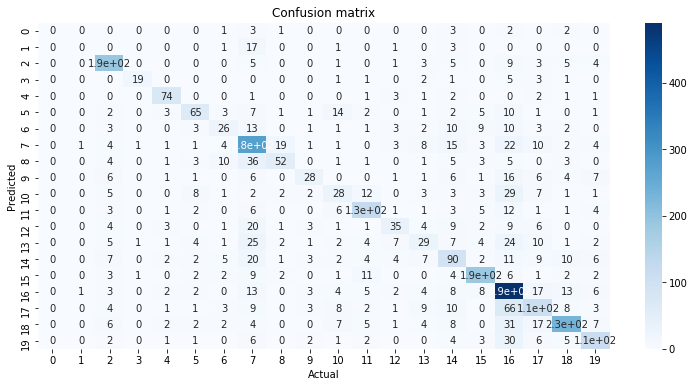

In [104]:
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

## 4. Fit the neural network model

In [105]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced', 
                                                       np.unique(df2['type']), 
                                                       df2['type']))

class_weights

[0.29589716956634643,
 0.450751582278481,
 0.5876740587931923,
 0.6910248635536689,
 0.7276500638569604,
 0.8299344501092498,
 0.8652239939255885,
 0.9036478984932593,
 0.9409578860445913,
 1.1845114345114345,
 1.4424050632911392,
 1.5588235294117647,
 1.6049295774647887,
 1.6419308357348703,
 1.8173843700159489,
 1.9313559322033897,
 2.1378986866791743,
 5.3,
 9.264227642276422,
 9.495833333333334]

In [106]:
weights = {}
for index, weight in enumerate(class_weights) :
    weights[index] = weight
    
weights

{0: 0.29589716956634643,
 1: 0.450751582278481,
 2: 0.5876740587931923,
 3: 0.6910248635536689,
 4: 0.7276500638569604,
 5: 0.8299344501092498,
 6: 0.8652239939255885,
 7: 0.9036478984932593,
 8: 0.9409578860445913,
 9: 1.1845114345114345,
 10: 1.4424050632911392,
 11: 1.5588235294117647,
 12: 1.6049295774647887,
 13: 1.6419308357348703,
 14: 1.8173843700159489,
 15: 1.9313559322033897,
 16: 2.1378986866791743,
 17: 5.3,
 18: 9.264227642276422,
 19: 9.495833333333334}

In [107]:
# create the train and test sets suitable for NN model
dataset_train = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

In [108]:
for text, target in dataset_train.take(5):
    print('Desc: {}, label: {}'.format(text, target))

Desc: b' russia   magadan government shuts   businesses   related   provision  services   field  cultural  entertainment leisure   organization  advertising  theater  concert performances  entertainment events  exhibitions  starting  april ', label: b'Restriction and Regulation of Businesses'
Desc: b' march   montana governor steve bullock issued  executive order declaring  state  emergency  exist within  state  montana related   communicable disease covid- novel coronavirus   emergency order allows  governor  direct  coordinated response   outbreak  communicable disease   includes mobilizing  available state resources    emergency funds  personnel   national guard   also allows  governor  take additional steps  warranted ', label: b'Declaration of Emergency'
Desc: b' may      ministry  health  labour  welfare    mhlw  issued   basic policies  novel coronavirus control   published  march     revised  may       order  regulate    going  workplaces    noted    ii  based   expectation   d

In [109]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(category_codes.keys())),
        values = tf.constant(list(category_codes.values()))
    ),
    default_value=tf.constant(-1),
    name="target_encoding"
)

@tf.function
def target(x):
    return table.lookup(x)

In [131]:
def fetch(text, labels):
    '''
    Purpose: one hot encoding the labels of the dataset
    '''
    return text, tf.one_hot(target(labels), 19)

train_data_fetch = dataset_train.map(fetch)
test_data_fetch = dataset_test.map(fetch)

# get a batch of data
train_data, train_labels = next(iter(dataset_train.map(fetch).batch(1000)))

#### Start creating a model

I'm going to fit the model without the dropout layers first, then compare it with the dropout layers method. For the model, I'm using an open-source embedding layer that handles the tokenization task for us.

In [132]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, output_shape=[128],input_shape=[], dtype=tf.string,
                          trainable=True)
#demonstrate how this layer tokenize the text
hub_layer(train_data[:1])

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[-0.01621816,  0.40372285,  0.00164725, -0.37480858,  0.08084103,
         0.20680235,  0.04397368, -0.30214432, -0.18861702,  0.30879438,
         0.16946974, -0.14245698, -0.05299588,  0.19755208, -0.07637328,
        -0.03807335, -0.02310325,  0.01548214,  0.08777677, -0.09021135,
        -0.01757798, -0.06095961,  0.1357396 ,  0.05659243,  0.260177  ,
        -0.05180504, -0.0177313 ,  0.02200496, -0.03014481,  0.17852491,
         0.10194247, -0.22433169, -0.16518947,  0.3761263 , -0.03583104,
         0.0852128 , -0.02257515, -0.04823471, -0.03777955, -0.05221266,
        -0.16312662,  0.19729845, -0.03254265,  0.23602825, -0.16145404,
         0.08150919,  0.0801242 , -0.24954356,  0.19191559,  0.22755569,
         0.05627486, -0.01934076,  0.40533257, -0.08100396,  0.09688789,
        -0.10653715,  0.17031918, -0.09386241, -0.02731524,  0.15563515,
        -0.12421128,  0.24334484,  0.09610028,  0.18665425,  0.03220046,
 

In [133]:
#build the basic model without dropout
model_wo_dropout = tf.keras.Sequential()
model_wo_dropout.add(hub_layer)
for units in [128, 128, 64, 32]:
    model_wo_dropout.add(tf.keras.layers.Dense(units, activation='relu'))
model_wo_dropout.add(tf.keras.layers.Dense(19, activation='softmax'))

model_wo_dropout.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_24 (Dense)             (None, 19)                627       
Total params: 124,686,675
Trainable params: 124,686,675
Non-trainable params: 0
________________________________________

In [134]:
#compile the model
model_wo_dropout.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [135]:
train_data_fetch = train_data_fetch.shuffle(70000).batch(512)
test_data_fetch = test_data_fetch.batch(512)

In [136]:
#fit the model
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True, verbose=1)
text_classifier_wo_dropout = model_wo_dropout.fit(train_data_fetch, epochs=25, validation_data = test_data_fetch,
                   verbose=1, class_weight=weights, callbacks =[earlystopping])

Epoch 1/25
38/38 [==============================] - 99s 3s/step - loss: 4.8280 - accuracy: 0.1121 - val_loss: 2.3830 - val_accuracy: 0.1907
Epoch 2/25
38/38 [==============================] - 93s 2s/step - loss: 2.8414 - accuracy: 0.3471 - val_loss: 1.7929 - val_accuracy: 0.4738
Epoch 3/25
38/38 [==============================] - 86s 2s/step - loss: 1.8643 - accuracy: 0.5363 - val_loss: 1.3930 - val_accuracy: 0.5700
Epoch 4/25
38/38 [==============================] - 125s 3s/step - loss: 1.2266 - accuracy: 0.6705 - val_loss: 1.1417 - val_accuracy: 0.6440
Epoch 5/25
38/38 [==============================] - 110s 3s/step - loss: 0.8423 - accuracy: 0.7531 - val_loss: 1.0806 - val_accuracy: 0.6791
Epoch 6/25
38/38 [==============================] - 115s 3s/step - loss: 0.5987 - accuracy: 0.8087 - val_loss: 1.0124 - val_accuracy: 0.7066
Epoch 7/25
38/38 [==============================] - 98s 3s/step - loss: 0.4260 - accuracy: 0.8495 - val_loss: 1.0527 - val_accuracy: 0.7052
Epoch 8/25
38/38 

In [137]:
#evaluate the model
test_length = len(list(dataset_test))
results = model_wo_dropout.evaluate(dataset_test.map(fetch).batch(test_length), verbose=2)
print(results)

1/1 - 0s - loss: 1.0124 - accuracy: 0.7066
[1.01235032081604, 0.7066393494606018]


In [140]:
#training errors
y_train_pred = model_wo_dropout.predict(train_data)

print(classification_report(train_labels.numpy().argmax(axis=1), y_train_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       1.00      0.12      0.21        25
           2       1.00      0.25      0.40         8
           3       0.93      0.89      0.91        63
           4       0.74      0.94      0.83        31
           5       0.88      0.72      0.79        40
           6       0.75      0.30      0.43        20
           7       0.83      0.96      0.89       120
           8       0.83      0.69      0.75        29
           9       0.73      0.79      0.76        38
          10       0.88      0.90      0.89        51
          11       0.84      0.95      0.89        38
          12       0.83      0.62      0.71         8
          13       0.78      1.00      0.87        45
          14       0.69      1.00      0.82        52
          15       0.87      0.97      0.92       154
          16       0.80      0.92      0.85        76
          17       0.97    

In [138]:
# test errors
test_data, test_labels = next(iter(dataset_test.map(fetch).batch(test_length)))
y_pred = model_wo_dropout.predict(test_data)

print(classification_report(test_labels.numpy().argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.40      0.05      0.09        84
           2       1.00      0.39      0.57        33
           3       0.82      0.84      0.83       227
           4       0.65      0.80      0.72        86
           5       0.75      0.61      0.67       118
           6       0.44      0.18      0.26        87
           7       0.66      0.77      0.71       377
           8       0.65      0.52      0.58       125
           9       0.61      0.52      0.56       107
          10       0.74      0.79      0.76       172
          11       0.54      0.64      0.58        99
          12       0.71      0.22      0.33        23
          13       0.58      0.70      0.64       185
          14       0.64      0.87      0.74       232
          15       0.83      0.87      0.85       581
          16       0.63      0.78      0.70       237
          17       0.84    

#### Model with Dropout layers for confirmation of overfitting

To confirm whether our model overfits the data or not, we train a secondary neural network with several dropout layers and compare the results.\
** Dropout layer is a tool to regularize neural network, in which a number of layer outputs at random are ignored so that the sparser network will have to adapt to correct mistakes from prior layers. We can grid search the best dropout parameter between the range 0.1-1.0. Here, I used 0.3 as the parameter

In [141]:
# re-create train, test data for fitting the model
train_data_fetch_dropout = dataset_train.map(fetch)
test_data_fetch_dropout = dataset_test.map(fetch)

In [142]:
# build a similar model but with the dropout layers
model = tf.keras.Sequential()
model.add(hub_layer)
for units in [128, 128, 64]:
    model.add(tf.keras.layers.Dense(units, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(19, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_25 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)               

**Brief discuss/note: after removing the final dropout layer (the dropout right before the output layer), the performance improves by a few percentage points, and the loss is also reduced across the epochs during training. This is because the output layer can't correct the errors from the previous layers anymore, so adding another dropout layer will end up hurting the model's performance

In [143]:
#compile the model
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [144]:
train_data_fetch_dropout = train_data_fetch_dropout.shuffle(10000).batch(1500)
test_data_fetch_dropout = test_data_fetch_dropout.batch(512)

In [145]:
#fit the model
text_classifier = model.fit(train_data_fetch_dropout, epochs=100, validation_data = test_data_fetch_dropout,
                   verbose=1, class_weight=weights, callbacks =[earlystopping])

Epoch 1/100
13/13 [==============================] - 41s 3s/step - loss: 5.7411 - accuracy: 0.0975 - val_loss: 2.7204 - val_accuracy: 0.1720
Epoch 2/100
13/13 [==============================] - 34s 3s/step - loss: 4.6339 - accuracy: 0.1567 - val_loss: 2.4556 - val_accuracy: 0.2717
Epoch 3/100
13/13 [==============================] - 30s 2s/step - loss: 3.4712 - accuracy: 0.2430 - val_loss: 2.1352 - val_accuracy: 0.2828
Epoch 4/100
13/13 [==============================] - 31s 2s/step - loss: 2.7108 - accuracy: 0.3168 - val_loss: 1.9548 - val_accuracy: 0.3767
Epoch 5/100
13/13 [==============================] - 27s 2s/step - loss: 2.3078 - accuracy: 0.3932 - val_loss: 1.8269 - val_accuracy: 0.4147
Epoch 6/100
13/13 [==============================] - 32s 2s/step - loss: 1.9920 - accuracy: 0.4550 - val_loss: 1.6674 - val_accuracy: 0.4955
Epoch 7/100
13/13 [==============================] - 30s 2s/step - loss: 1.6581 - accuracy: 0.5263 - val_loss: 1.5019 - val_accuracy: 0.5423
Epoch 8/100
1

In [146]:
test_length = len(list(dataset_test))
results = model.evaluate(dataset_test.map(fetch).batch(test_length), verbose=2)
print(results)

1/1 - 0s - loss: 1.1799 - accuracy: 0.6809
[1.1798758506774902, 0.6809008717536926]


We look closer at the confusing matrices

In [148]:
# training errors
y_train_pred_dropout = model.predict(train_data)

print(classification_report(train_labels.numpy().argmax(axis=1), y_train_pred_dropout.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00         8
           3       0.84      0.90      0.87        63
           4       0.71      0.81      0.76        31
           5       0.76      0.62      0.68        40
           6       0.00      0.00      0.00        20
           7       0.83      0.95      0.89       120
           8       0.70      0.66      0.68        29
           9       0.57      0.79      0.66        38
          10       0.82      0.90      0.86        51
          11       0.63      0.95      0.76        38
          12       0.00      0.00      0.00         8
          13       0.74      0.96      0.83        45
          14       0.78      1.00      0.87        52
          15       0.89      0.99      0.94       154
          16       0.88      0.92      0.90        76
          17       0.96    

In [147]:
# testing errors
test_data, test_labels = next(iter(dataset_test.map(fetch).batch(test_length)))
y_pred = model.predict(test_data)

print(classification_report(test_labels.numpy().argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.00      0.00      0.00        84
           2       0.00      0.00      0.00        33
           3       0.75      0.81      0.78       227
           4       0.62      0.72      0.67        86
           5       0.64      0.56      0.60       118
           6       0.00      0.00      0.00        87
           7       0.68      0.79      0.73       377
           8       0.49      0.39      0.44       125
           9       0.46      0.43      0.44       107
          10       0.68      0.83      0.75       172
          11       0.37      0.62      0.46        99
          12       0.00      0.00      0.00        23
          13       0.57      0.67      0.62       185
          14       0.69      0.86      0.77       232
          15       0.81      0.88      0.84       581
          16       0.63      0.76      0.69       237
          17       0.84    

### 5. Discussion of the result and next steps

- The performance of the model with and without dropout layers are pretty much the same. The diverge between train and test errors don't improve even after using the dropout layers. In fact, with the dropout layer, the model fails to predict the labels for a lot more categories than the model without the dropout layer (many have 0% accuracy). However, after examining the big dataset and the fact that regulization doesn't significantly improve the model, I don't think that overfitting is not that big of a problem in this model. Further analysis can involve fitting models on different dropout values to confirm if the performance doesn't improve because we didn't choose a good dropout rate, or because of the dataset itself.
- The logistic regression, as well as other ML models, don't have that big of a gap between the training and testing errors. It can be said that these ML models don't suffer from overfitting as much as the neural network model, however, these models can hardly be improve further, given that we already use the best parameters. Meanwhile, the neural network stands a good chance of improving beyond this point. And since our interest lies in getting more accurate prediction, we will go with the neural network.
- It is observed that the overall accuracy for both models goes up after I added more data points. 
- The accuracy shows slight fluctuations across different fitting attempts, but on average, the result is in the range [0.66 - 0.71], which is ~5-10% inccrease from the average of the results of the machine learning models I fitted (which is ~59-60%). Looking at the confusion matrix, the metrics within each category also improves.
- Another source that might affect the predictive power of the model is the fact that a lot of categories (take health resources, health monitoring and health testing) share many words in common, so one of the next steps from here is to identify and develop a collection of stopwords that appear a lot across different categories to reduce the similarity between these categories and see if this increases the performance even further.

Reference: https://www.youtube.com/watch?v=dkpS2g4K08s&t=775s